In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
DATA_DIR = r"C:\Users\patka\Downloads\Vision_artificial\archive"


In [ ]:
IMG_SIZE = (320, 258)
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

print("Clases:", train_ds.class_names)
print("Número de clases:", len(train_ds.class_names))

for x, y in train_ds.take(1):
    print("Batch imágenes:", x.shape)
    print("Batch etiquetas:", y.shape)

Found 70549 files belonging to 15 classes.
Using 56440 files for training.
Found 70549 files belonging to 15 classes.
Using 14109 files for validation.
Clases: ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']
Número de clases: 15
Batch imágenes: (128, 320, 258, 3)
Batch etiquetas: (128, 15)


In [ ]:
data_augmentation = keras.Sequential([
layers.RandomFlip('horizontal'),
layers.RandomRotation(0.1),
layers.RandomZoom(0.1),
])

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from collections import Counter
class_names = train_ds.class_names

IMG_SIZE = (320, 258)
NUM_CLASSES = len(class_names)

base_model = MobileNetV2(
input_shape=IMG_SIZE + (3,),
include_top=False,
weights='imagenet'
)
base_model.trainable = False


inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)


model = keras.Model(inputs, outputs, name='mobilenet_transfer')


model.compile(
optimizer=keras.optimizers.Adam(1e-3),
loss='categorical_crossentropy',
metrics=['accuracy']
)


model.summary()


C:\Users\patka\AppData\Local\Temp\ipykernel_16224\4102832660.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "mobilenet_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 320, 258, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 320, 258, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 320, 258, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 320, 258, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 10, 9, 1280)    │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


callbacks = [
EarlyStopping(patience=5, restore_best_weights=True),
ModelCheckpoint('mobilenet_best.h5', save_best_only=True),
CSVLogger('training_log_mobilenet.csv')
]


history = model.fit(
train_ds,
validation_data=val_ds,
epochs=6,
callbacks=callbacks
)


Epoch 1/6
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7299 - loss: 0.9432   

441/441 ━━━━━━━━━━━━━━━━━━━━ 1785s 4s/step - accuracy: 0.8703 - loss: 0.4829 - val_accuracy: 0.9689 - val_loss: 0.1582
Epoch 2/6
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9569 - loss: 0.1636   

441/441 ━━━━━━━━━━━━━━━━━━━━ 1794s 4s/step - accuracy: 0.9603 - loss: 0.1464 - val_accuracy: 0.9828 - val_loss: 0.0901
Epoch 3/6
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9676 - loss: 0.1149   

441/441 ━━━━━━━━━━━━━━━━━━━━ 1804s 4s/step - accuracy: 0.9697 - loss: 0.1078 - val_accuracy: 0.9875 - val_loss: 0.0668
Epoch 4/6
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9709 - loss: 0.0981   

441/441 ━━━━━━━━━━━━━━━━━━━━ 1827s 4s/step - accuracy: 0.9721 - loss: 0.0942 - val_accuracy: 0.9865 - val_loss: 0.0564
Epoch 5/6
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9744 - loss: 0.0832   

441/441 ━━━━━━━━━━━━━━━━━━━━ 1821s 4s/step - accuracy: 0.9752 - loss: 0.0817 - val_accuracy: 0.9843 - val_loss: 0.0549
Epoch 6/6
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9748 - loss: 0.0798   

441/441 ━━━━━━━━━━━━━━━━━━━━ 1820s 4s/step - accuracy: 0.9765 - loss: 0.0759 - val_accuracy: 0.9882 - val_loss: 0.0471


In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print('Validation accuracy:', val_acc)

111/111 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9882 - loss: 0.0471
Validation accuracy: 0.9881635904312134


In [ ]:
from sklearn.metrics import classification_report


y_true, y_pred = [], []
for x, y in val_ds:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


print(classification_report(y_true, y_pred, target_names=class_names))


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 693ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 811ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 2400x2000 with 0 Axes>

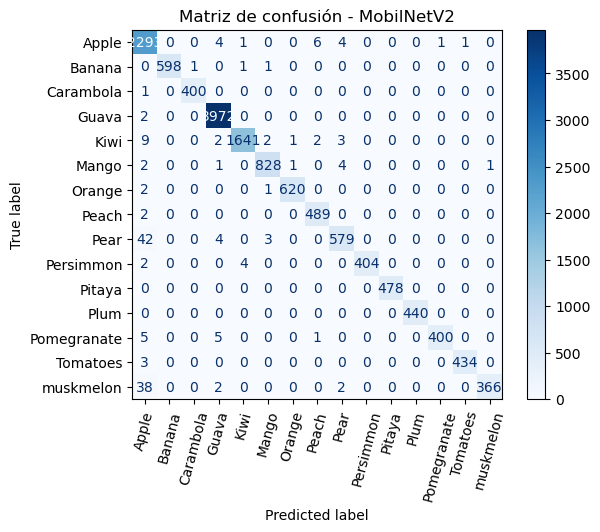

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_pred

# Crear matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar matriz de confusión
plt.figure(figsize=(24, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=75)
plt.title("Matriz de confusión - MobilNetV2")
plt.show()
plt.close()

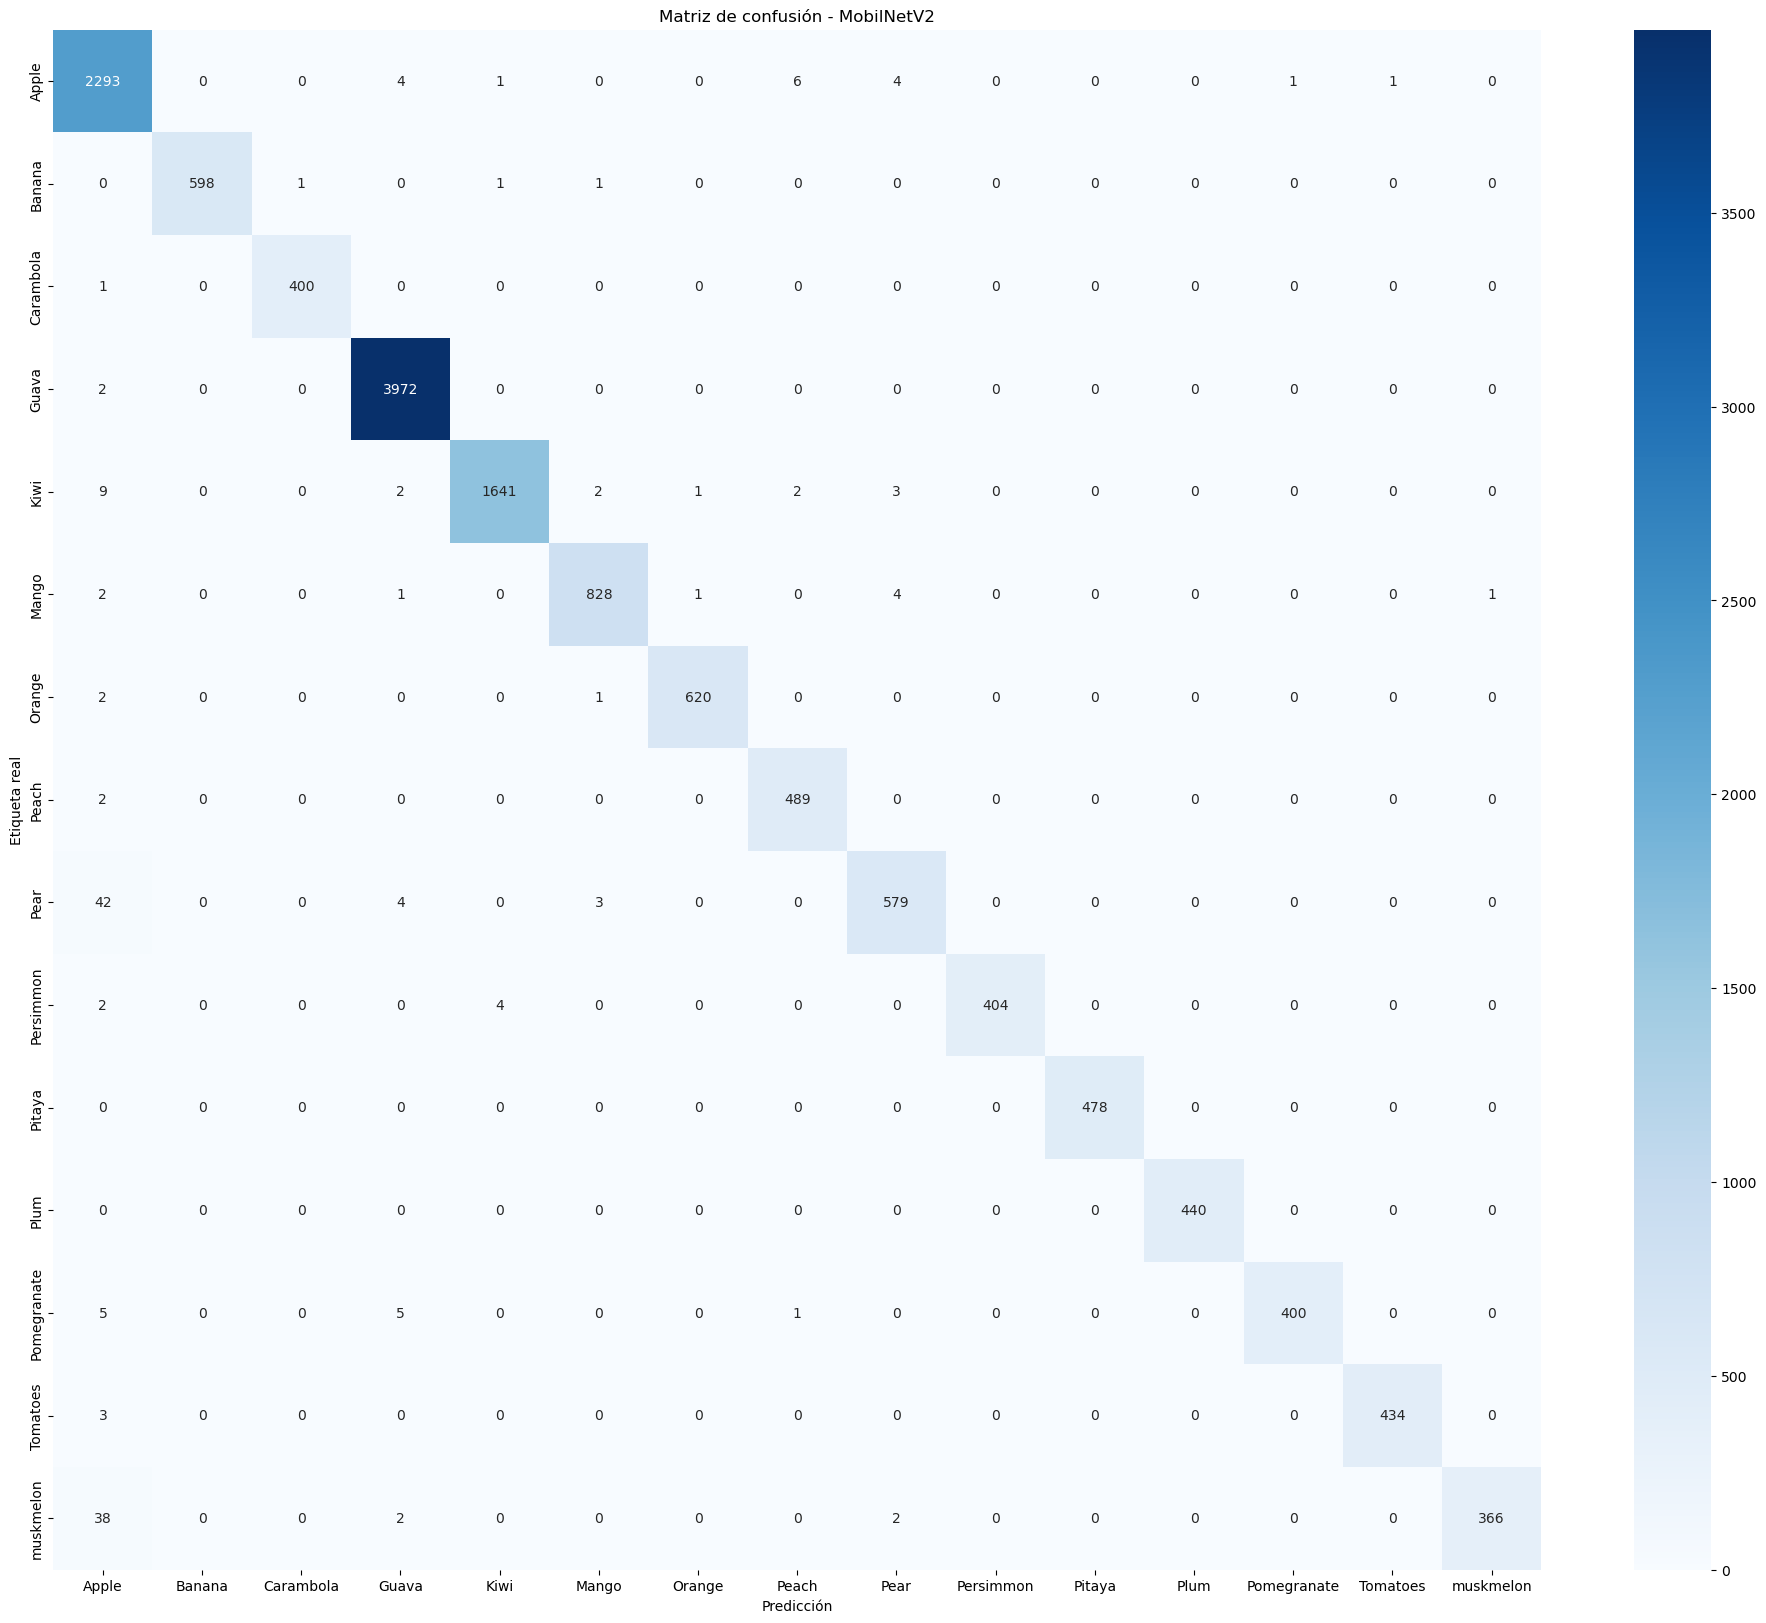

In [ ]:
import seaborn as sns

plt.figure(figsize=(24, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - MobilNetV2")
plt.show()

Normalized confusion matrix


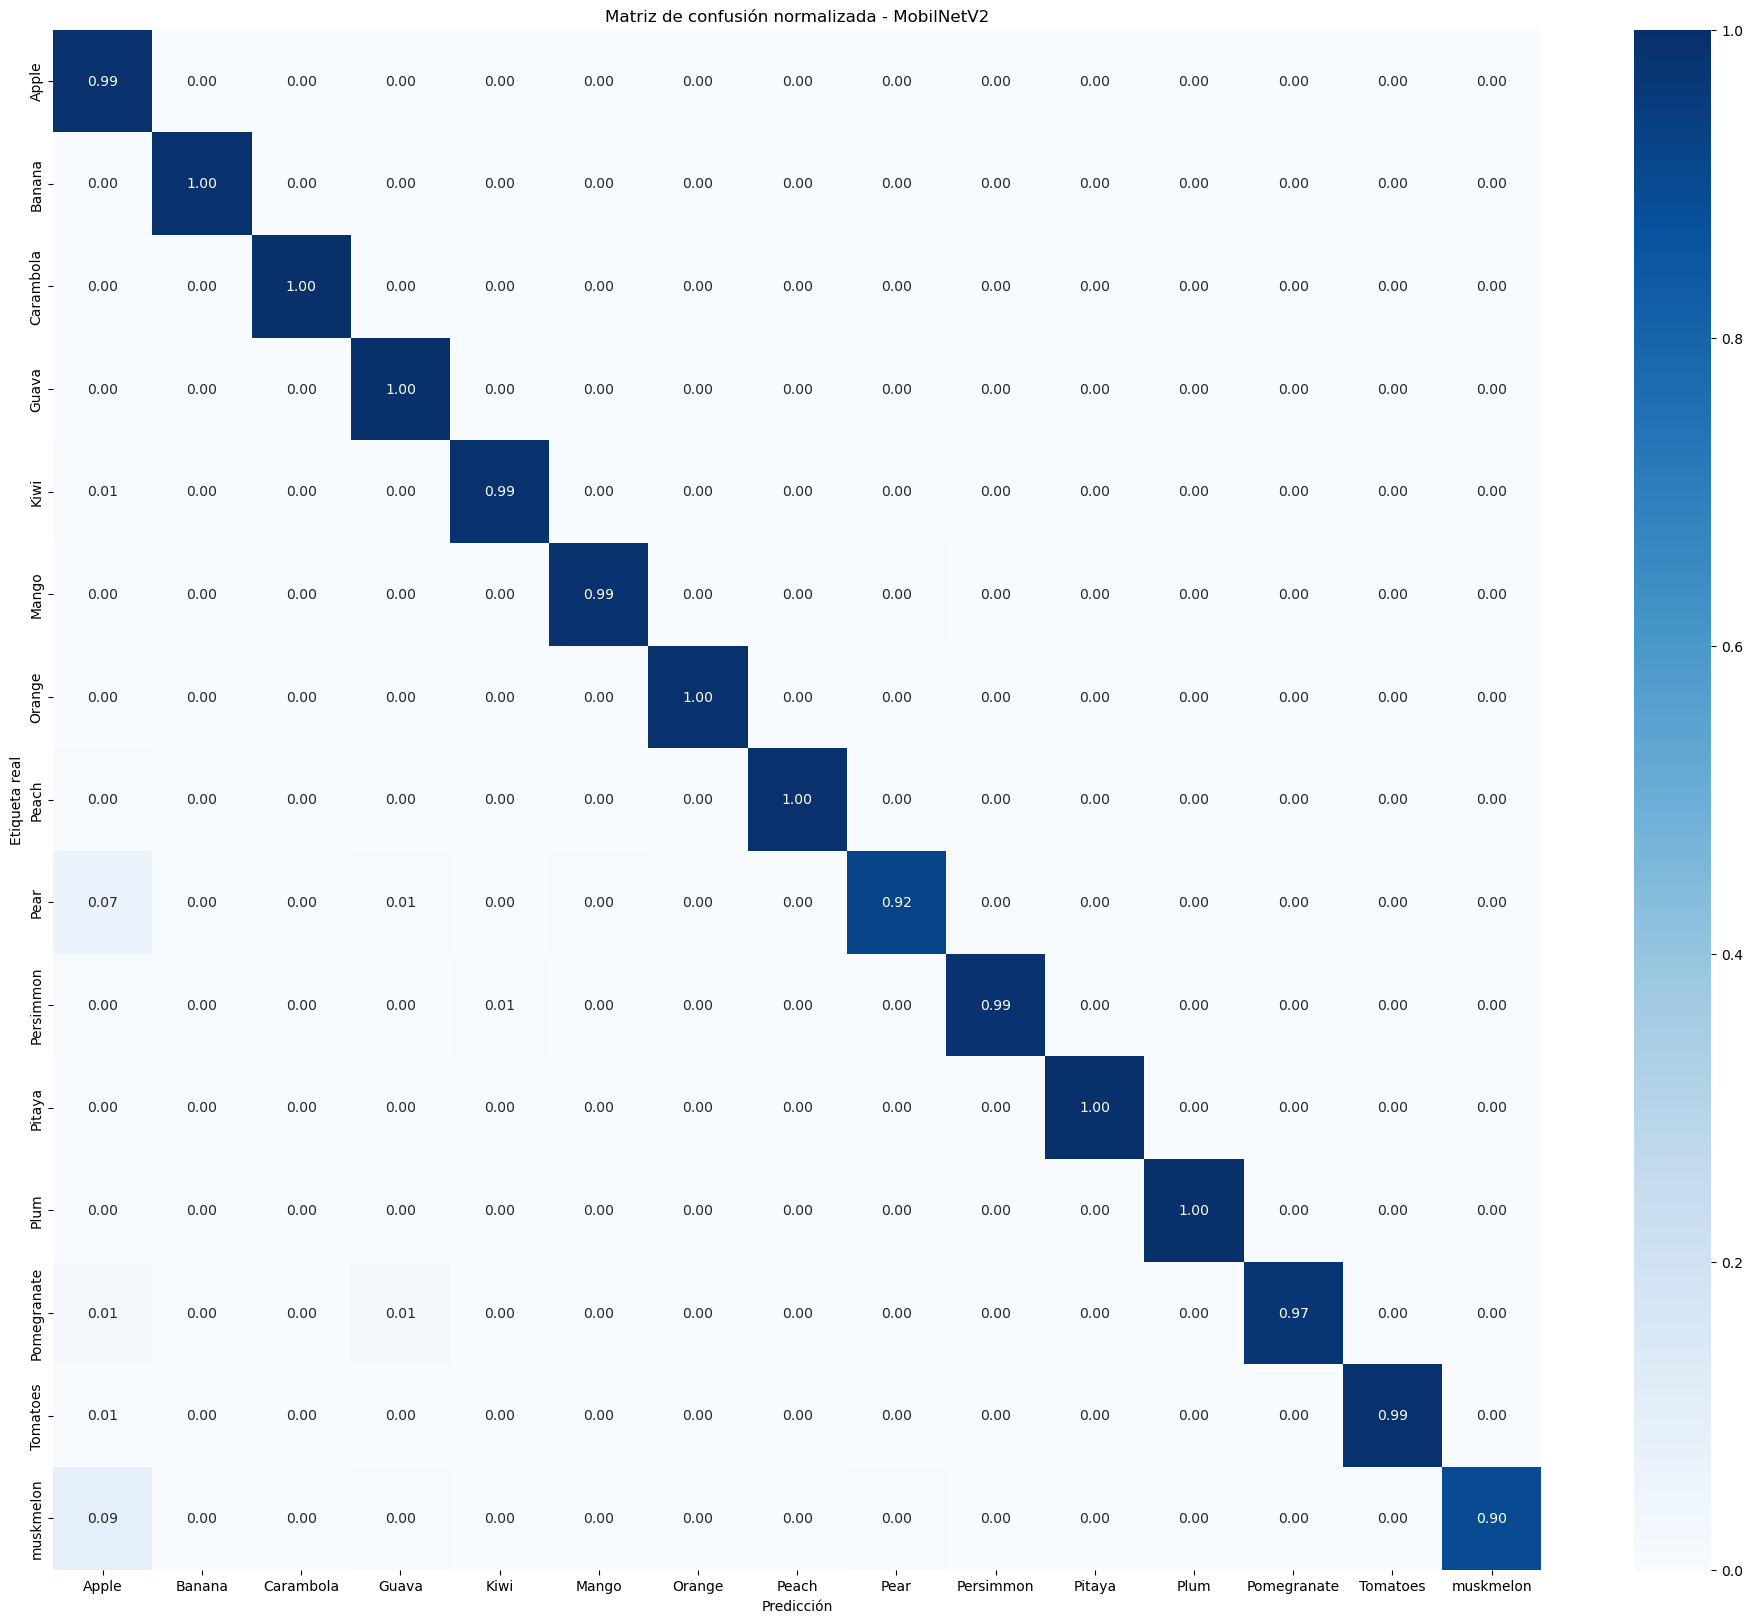

In [ ]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')

plt.figure(figsize=(24, 20))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión normalizada - MobilNetV2")
plt.show()

In [ ]:
model.save("mobilenet_fruits_model.keras")
